In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import matplotlib as mpl
from matplotlib import rc

/tmp/ipykernel_3133860/3939874329.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from Utils import load
from Utils import generator
from Utils import metrics
from train import *
from prune import *

In [3]:
## Random Seed and Device ##
torch.manual_seed(1)
device = load.device(0)

 ## Model, Loss, Optimizer ##
print('Loading {} dataset.'.format('cifar10'))
input_shape, num_classes = load.dimension('cifar10') 
    
print('Creating {}-{} model.'.format('lottery', 'vgg16'))
model = load.model('vgg16', 'lottery')(input_shape, 
                                       num_classes, 
                                    False, 
                                    pretrained=False).to(device)

Loading cifar10 dataset.
Creating lottery-vgg16 model.


In [4]:
for name, param in model.named_parameters():
    print(name)

layers.0.conv.weight
layers.0.conv.bias
layers.1.conv.weight
layers.1.conv.bias
layers.3.conv.weight
layers.3.conv.bias
layers.4.conv.weight
layers.4.conv.bias
layers.6.conv.weight
layers.6.conv.bias
layers.7.conv.weight
layers.7.conv.bias
layers.8.conv.weight
layers.8.conv.bias
layers.10.conv.weight
layers.10.conv.bias
layers.11.conv.weight
layers.11.conv.bias
layers.12.conv.weight
layers.12.conv.bias
layers.14.conv.weight
layers.14.conv.bias
layers.15.conv.weight
layers.15.conv.bias
layers.16.conv.weight
layers.16.conv.bias
fc.weight
fc.bias


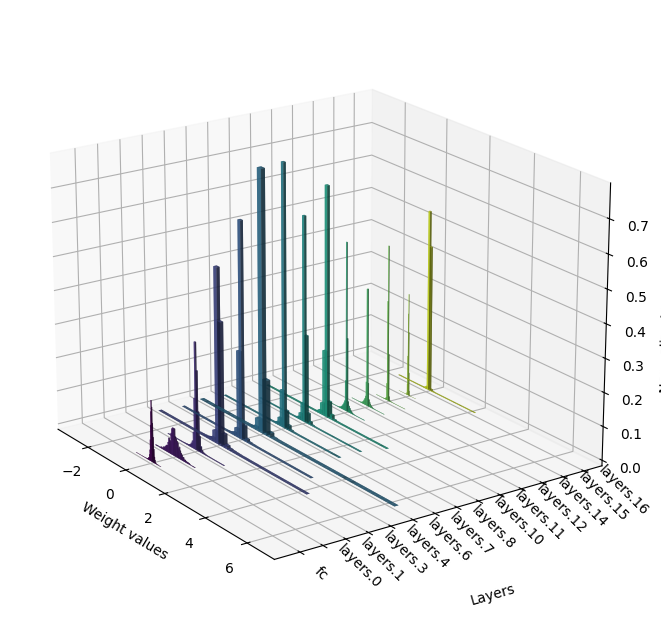

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

result_dir = 'Results/data/singleshot/27'
state_dict = torch.load("{}/model.pt".format(result_dir))
model.load_state_dict(state_dict)

# Prepare your model's layers and weights
# You should extract the weights from your model's Conv2d layers specifically
weights = []  # List to hold the weights arrays
layer_names = []  # List to hold the names of the layers

# Iterate through the model's modules and parameters
for name, module in model.named_modules():
    # Check if the module is a convolutional layer
    if hasattr(module, 'conv'):
        conv_weights = module.conv.weight.data.cpu().numpy()  # Extract the convolutional weights
        weights.append(conv_weights.flatten())  # Flatten and append the weights
        layer_names.append(f'{name}')  # Append the layer name for weights

    # Check if the module is the fully connected layer by the attribute 'fc'
    if hasattr(module, 'fc'):
        fc_weights = module.fc.weight.data.cpu().numpy()  # Extract the fully connected layer weights
        weights.append(fc_weights.flatten())  # Flatten and append the weights
        layer_names.append(f'fc')  # Append the layer name for weights

num_layers = len(layer_names)
color_map = cm.viridis  # Access the colormap directly without using get_cmap
colors = [color_map(i / num_layers) for i in range(num_layers)]

# Prepare the figure and axes
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# Number of bins for the histogram
bins = 50
# Positions for each layer along the y-axis
layer_positions = np.arange(len(layer_names))

# Iterate through the layers and weights
for i, (layer_weights, layer_name) in enumerate(zip(weights, layer_names)):
    # Compute the histogram
    hist, edges = np.histogram(layer_weights, bins=bins)
    # # Normalize the histogram
    hist = hist / np.sum(hist)  # Normalize to the highest peak
    # The x and y coordinates of each bar
    xpos, ypos = np.meshgrid(edges[:-1] + 0.25, [layer_positions[i]], indexing="ij")
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    zpos = np.zeros_like(xpos)

    # The size of each bar
    dx = dy = np.ones_like(zpos) * (edges[1] - edges[0])  # Width of bars
    dz = hist  # Height of bars (normalized histogram values)

    # Plot the bars
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors[i], zsort='average', alpha=0.7)

# Set the y-ticks and y-tick labels to the layer names
adjusted_layer_positions = layer_positions + dy[0]*2  # Add half the depth to shift labels to center

# Set the adjusted y-ticks and y-tick labels to the layer names
ax.set_yticks(adjusted_layer_positions)
ax.set_yticklabels(layer_names, rotation=-45, ha='left', va='center')


# Set labels for the other axes
ax.set_xlabel('Weight values')
ax.set_ylabel('Layers', labelpad=25) 
ax.set_zlabel('Normalized Count')

# Adjust the viewing angle if necessary
ax.view_init(elev=20, azim=-35)

plt.savefig(f'weight_hist_synflow.png', dpi=300, bbox_inches='tight')

In [14]:
metrics.flop(model, input_shape, device)

{'layers.0.conv': {'weight': 1769472, 'bias': 65536},
 'layers.0': {},
 'layers.1.conv': {'weight': 37748736, 'bias': 65536},
 'layers.1': {},
 'layers.2': {},
 'layers.3.conv': {'weight': 18874368, 'bias': 32768},
 'layers.3': {},
 'layers.4.conv': {'weight': 37748736, 'bias': 32768},
 'layers.4': {},
 'layers.5': {},
 'layers.6.conv': {'weight': 18874368, 'bias': 16384},
 'layers.6': {},
 'layers.7.conv': {'weight': 37748736, 'bias': 16384},
 'layers.7': {},
 'layers.8.conv': {'weight': 37748736, 'bias': 16384},
 'layers.8': {},
 'layers.9': {},
 'layers.10.conv': {'weight': 18874368, 'bias': 8192},
 'layers.10': {},
 'layers.11.conv': {'weight': 37748736, 'bias': 8192},
 'layers.11': {},
 'layers.12.conv': {'weight': 37748736, 'bias': 8192},
 'layers.12': {},
 'layers.13': {},
 'layers.14.conv': {'weight': 9437184, 'bias': 2048},
 'layers.14': {},
 'layers.15.conv': {'weight': 9437184, 'bias': 2048},
 'layers.15': {},
 'layers.16.conv': {'weight': 9437184, 'bias': 2048},
 'layers.16

In [15]:
result_dir = 'Results/data/singleshot/17'
state_dict = torch.load("{}/model.pt".format(result_dir))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [36]:
result_dir = 'Results/data/singleshot/28'
file = "{}/compression.pkl".format(result_dir)
prune_result = pd.read_pickle(file)
prune_result['layer_FLOP'] = (prune_result['sparsity'] * prune_result['flops']).astype(int)

filtered_prune_result = prune_result[prune_result['param'] != 'bias']

print(filtered_prune_result[['module', 'param', 'flops', 'sparsity', 'layer_FLOP']])

            module   param     flops  sparsity  layer_FLOP
0    layers.0.conv  weight   1769472  0.997685     1765376
2    layers.1.conv  weight  37748736  0.983805    37137408
4    layers.3.conv  weight  18874368  0.969618    18300928
6    layers.4.conv  weight  37748736  0.940484    35502079
8    layers.6.conv  weight  18874368  0.881917    16645631
10   layers.7.conv  weight  37748736  0.766761    28944256
12   layers.8.conv  weight  37748736  0.766454    28932671
14  layers.10.conv  weight  18874368  0.546605    10316815
16  layers.11.conv  weight  37748736  0.232451     8774719
18  layers.12.conv  weight  37748736  0.232695     8783952
20  layers.14.conv  weight   9437184  0.211457     1995555
22  layers.15.conv  weight   9437184  0.211553     1996460
24  layers.16.conv  weight   9437184  0.210051     1982292
26              fc  weight      5120  0.997656        5107
